# [IAPR 2020:][iapr2020] Lab 2 ‒  Object description

**Authors:** Catinca Mujdei, Erick Maraz
**Due date:** 24.04.2020

[iapr2020]: https://github.com/LTS5/iapr-2020

## Extract relevant data
We first need to extract the `lab-02-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

## Part 1
In the `lab-02-data/part1` folder, you will find 28x28 grey-scale pictures of handwritten "0" and "1".
These digits have been extracted from MNIST dataset (http://yann.lecun.com/exdb/mnist/).

Your goal is to extract, from each of those images, a 2-dimensional feature vector (i.e. 2 features) and to plot them all on a 2D graph.
If you have chosen good features, the vectors of the "0"'s should nicely cluster in one part of the plane and those of the "1"'s in another.

Please try first the Fourier Descriptors.
You can make several attempts: e.g. with and without invariance to rotation, translation, scaling, etc.
You can also for instance rotate the images and assess the invariance in rotation.

**Note:** for the Fourier descriptors, the u_k signal has to be constructed by following the contour point after point.
Some pre-processing (image binarization, possibly some Mathematical Morphology) might be useful.

Then feel free to try other features, the more you try, the better it will be (for you).

### 1.1 Data visualization

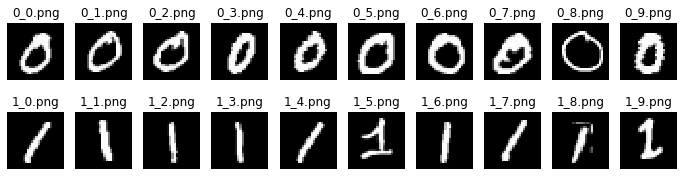

In [2]:
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline

# Load images
data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-02-data'
#  Load zeros
zeros_path = os.path.join(data_base_path, data_folder, 'part1', '0')
zeros_names = [nm for nm in os.listdir(zeros_path) if '.png' in nm]  # make sure to only load .png
zeros_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(zeros_path, nm) for nm in zeros_names])
zeros_im = skimage.io.concatenate_images(ic)
#  Load ones
ones_path = os.path.join(data_base_path, data_folder, 'part1', '1')
ones_names = [nm for nm in os.listdir(ones_path) if '.png' in nm]  # make sure to only load .png
ones_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(ones_path, nm) for nm in ones_names]))
ones_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(zeros_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], zeros_im, zeros_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], ones_im, ones_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

Our pre-processing approach consists of binarization and applying mathematical morphology techniques.

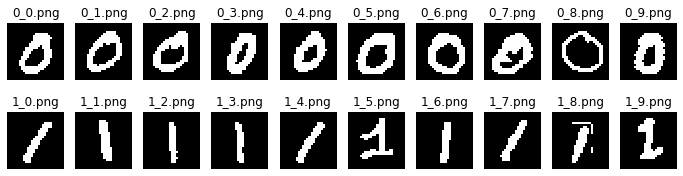

In [3]:
#1. Binarization
import numpy as np

### HISTOGRAM VISUALIZATION:
#fig, ax = plt.subplots(1, 1)
#ax.hist(ones_im[0].ravel(), bins=150, range=[0, 255])
#ax.set_xlim(0, 255);

def binarize(image, treshold):
    mask_white = image[:,:] > treshold
    image_binarized = np.zeros((im_h, im_w))
    image_binarized[mask_white] = 255
    return image_binarized

def binarize_images(images, treshold):
    images_binarized = np.zeros((nb_im, im_h, im_w))
    for i in range(nb_im):
        image = images[i]
        images_binarized[i] = binarize(image, treshold)
    return images_binarized

def show_numbers(first_processed, first_names, first_contours,
                 second_processed, second_names = None, second_contours = None, contours = True):
    if not contours: # to validate when we there are no contours
        second_names = second_processed
        second_processed = first_contours
        second_contours = first_contours # just to avoid error in loop
        
    fig, axes = plt.subplots(2, 10, figsize=(12, 3))
    for ax, im, nm, contour in zip(axes[0], first_processed, first_names, first_contours):
        ax.imshow(im, cmap='gray')
        if contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        ax.axis('off')
        ax.set_title(nm)
    for ax, im, nm, contour in zip(axes[1], second_processed, second_names, second_contours):
        ax.imshow(im, cmap='gray')
        if contours:
            ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
        ax.axis('off')
        ax.set_title(nm)

nb_im, im_h, im_w = zeros_im.shape
zeros_binarized = binarize_images(zeros_im, 40)
ones_binarized = binarize_images(ones_im, 40)

show_numbers(zeros_binarized, zeros_names, 
             ones_binarized, ones_names, contours = False)

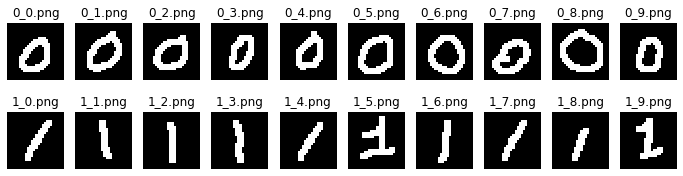

In [4]:
#2. Mathematical morphology
from skimage.morphology import opening, dilation, erosion, closing
from skimage.morphology import skeletonize
from skimage.transform import rotate
    
def straighten(image):
    digit_coordinates = np.argwhere(image>0)
    rows = list(digit_coordinates[:,0])
    cols = list(digit_coordinates[:,1])
    
    min_row = np.min(rows)
    max_col = cols[rows.index(min_row)]
    
    max_row = np.max(rows)
    min_col = cols[rows.index(max_row)]
    
    angle = 90 - np.arctan2(max_row-min_row, max_col-min_col) * 180 / np.pi
    return np.where(binarize(rotate(image, angle), 0.05) > 1, 1, 0)

def preprocess(image):
    selem_opening = np.ones((2, 2))
    selem_dilation = np.ones((3, 3))
    image = opening(image, selem_opening) #removes added noise
    image = skeletonize(np.where(image > 1, 1, 0)) #skeletonizes the digits
    #image = skeletonize(straighten(image)) #straightens the digits, which results in 'vertical' digits 1 if they are written using only one segment
    image = dilation(image, selem_dilation) #closes any opened zeros and smoothes the contours a little bit
    return image

def preprocess_images(images):
    images_preprocessed = np.zeros((nb_im, im_h, im_w))
    for i in range(nb_im):
        image = images[i]
        images_preprocessed[i] = preprocess(image)
    return images_preprocessed

zeros_processed = preprocess_images(zeros_binarized)
ones_processed = preprocess_images(ones_binarized)

show_numbers(zeros_processed, zeros_names, 
             ones_processed, ones_names, contours = False)

If we want to straighten the digits (so that the digits 1 consisting of only one line segment will become vertical), this can be done by uncommenting the fifth line in ```preprocess```.

### 1.2 Fourier descriptors
First, we obtain the outer contour of each hand-written digit with the function ```skimage.measure.find_contours```. (We could also consider the inner contour of each digit, in which case one has to change the ```max``` to ```min``` in the declaration of both the ```zeros_contours``` as the ```ones_contours``` variable.)

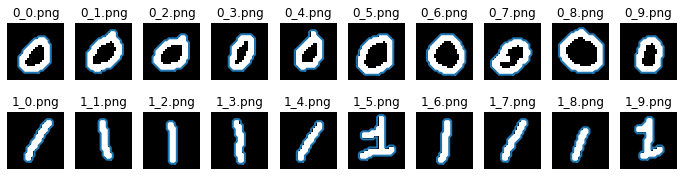

In [5]:
from skimage import measure

zeros_contours = [max(measure.find_contours(image, 0), key=len) for image in zeros_processed]
ones_contours = [max(measure.find_contours(image, 0), key=len) for image in ones_processed]

show_numbers(zeros_processed, zeros_names, zeros_contours,
            ones_processed, ones_names, ones_contours)

We now look at the DFT coefficients of each outer contour by plotting them in a graph.

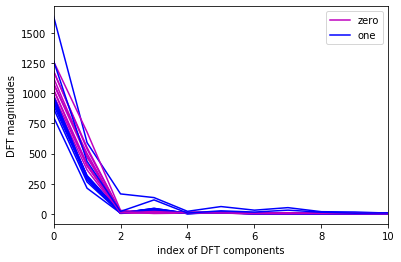

In [6]:
from numpy.fft import fft

zeros_dft_coeff = [fft(contour[:,1]+contour[:,0]*1j) for contour in zeros_contours]
ones_dft_coeff = [fft(contour[:,1]+contour[:,0]*1j) for contour in ones_contours]

for i in range(nb_im):
    dft_coeff = zeros_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='m')
    dft_coeff = ones_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='b')    
    
plt.xlim((0, 10))

plt.legend(('zero', 'one'))
plt.xlabel('index of DFT components')
plt.ylabel('DFT magnitudes')
plt.show()

Magenta displays the magnitude of the DFT coefficients for the 0 digits, and blue for the 1 digits. From the above plot we can conclude that the energy of the contour (signal) is concentrated in the low frequencies; we can for example choose the amplitude of the second and fourth coefficient for final clustering.
The next scatter plot visualizes this.

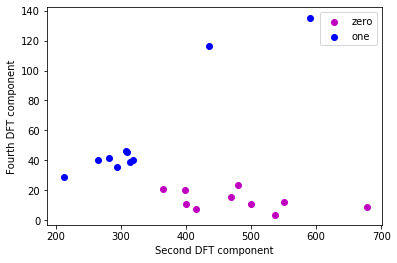

In [7]:
#zeros_first = [np.abs(zeros_dft_coeff[i][0]) for i in range(nb_im)]   <---- in case we want to consider the first coefficient
zeros_second = [np.abs(zeros_dft_coeff[i][1]) for i in range(nb_im)]
zeros_fourth = [np.abs(zeros_dft_coeff[i][3]) for i in range(nb_im)]
zero = plt.scatter(zeros_second, zeros_fourth, color='m')

#ones_first = [np.abs(ones_dft_coeff[i][0]) for i in range(nb_im)]     <---- in case we want to consider the first coefficient
ones_second = [np.abs(ones_dft_coeff[i][1]) for i in range(nb_im)]
ones_fourth = [np.abs(ones_dft_coeff[i][3]) for i in range(nb_im)]
one = plt.scatter(ones_second, ones_fourth, color='b')

plt.legend((zero, one), ('zero', 'one'))
plt.xlabel('Second DFT component')
plt.ylabel('Fourth DFT component')
plt.show()

We now show invariance to rotation. 
(Note first that the center around which we let the digits rotate is the center of the image itself. We opted for this convenience since we are now sure that the rotated digit still remains within the boundaries of the image. However, this choice of center of rotation does not affect our results; indeed, if we would choose to rotate around a different point, the new rotation would consist of a composition of a translation, a rotation around the center of the image, and another a translation. Invariance to translation of the second and fourth DFT coefficient is shown in a few cells more below. We can thus conclude that our choice of rotation around the image center is valid.)

In [8]:
from skimage.transform import rotate

def check_invariance_to_rotation(digit, index, degrees):
    # 'digit' specifies the kind of digit we want to check invariance to rotation for
    # 'index' specifies the index of the image within the array of images of the specified digit
    # 'degrees' specifies the number of degrees to rotate about
    
    assert 0 <= index < 10
    
    if digit == 0:
        image = zeros_processed[index]
        second_coeff_original = zeros_second[index]
        fourth_coeff_original = zeros_fourth[index]
    else:
        image = ones_processed[index]
        second_coeff_original = ones_second[index]
        fourth_coeff_original = ones_fourth[index]
    
    rotated_image = binarize(rotate(image, degrees), 0.5)
    #plt.imshow(rotated_image, cmap='gray')
    contour = max(measure.find_contours(rotated_image, 0), key=len)
    dft_coeff = fft(contour[:,1]+contour[:,0]*1j)
    second_coeff = np.abs(dft_coeff[1])
    fourth_coeff = np.abs(dft_coeff[3])
    
    if digit == 0:
        print('The red dot should belong to the magenta cluster.')
    else:
        print('The red dot should belong to the blue cluster.')
    
    zero = plt.scatter(zeros_second, zeros_fourth, color='m')
    one = plt.scatter(ones_second, ones_fourth, color='b')
    plt.scatter(second_coeff, fourth_coeff, color='red')
    original = plt.scatter(second_coeff_original, fourth_coeff_original, color='y')
    plt.legend((zero, one, original), ('zero', 'one', 'original'))
    plt.xlabel('Second DFT component')
    plt.ylabel('Fourth DFT component')
    plt.show()    

The red dot should belong to the blue cluster.


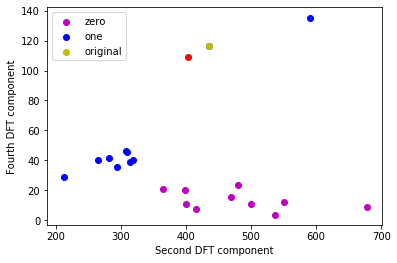

In [9]:
check_invariance_to_rotation(1, 9, 50)

By rotating the written digit, each DFT coefficient is only affected by the same phase change. The amplitude of each coefficient should therefore not change. This is however the case in the theoretical approach; in practice, the contour is not exactly the same after rotation due to the somewhat small resolution 28x28, which introduces difficulties in approximating the exact same original contour for rotations that are not multitudes of 90°. The quality of the reconstructed digit after rotation also depends on which binarizing treshold is chosen; the function ```skimage.transform.rotate``` introduces gray pixels after rotation, which therefore have to be rounded to 0 or 1 if we want to define the new contour. Therefore, even though the red dot always clearly belongs to the correct cluster, it does not exactly overlap with the original dot corresponding to no rotation.

Invariance to translation can also be checked efficiently. 
Note here that the Fourier descriptors are computed based on the contour of each digit; if the translation is such that the digit falls off the image or only just touches the boundary, the contour cannot be computed; these problems are handled in the code below.

In [10]:
def check_invariance_to_translation(digit, index, transl_vt, transl_hz):
    # 'digit' specifies the kind of digit we want to check invariance to translation for
    # 'index' specifies the index of the image within the array of images of the specified digit
    # 'transl_vt' specifies the amount of pixels to translate the image downwards
    # 'transl_hz' specifies the amount of pixels to translate the image to the right
    assert 0 <= index < 10
    
    if digit == 0:
        image = zeros_processed[index]
        second_coeff_original = zeros_second[index]
        fourth_coeff_original = zeros_fourth[index]
    else:
        image = ones_processed[index]
        second_coeff_original = ones_second[index]
        fourth_coeff_original = ones_fourth[index]
        
    digit_coordinates = np.argwhere(image>0)
    rows = list(digit_coordinates[:,0])
    cols = list(digit_coordinates[:,1])
    min_row = np.min(rows)
    max_row = np.max(rows)
    min_col = np.min(cols)
    max_col = np.max(cols)
    
    if (min_row + transl_vt < 1) or (max_row + transl_vt > im_h-2) or (min_col + transl_hz < 1 ) or (max_col + transl_hz > im_w-2):
        print("Invalid translation parameters")
    else:
        translated_image = np.roll(image, transl_vt, axis=0)
        translated_image = np.roll(translated_image, transl_hz, axis=1)
        
        contour = max(measure.find_contours(translated_image, 0), key=len)
        dft_coeff = fft(contour[:,1]+contour[:,0]*1j)
        second_coeff = np.abs(dft_coeff[1])
        fourth_coeff = np.abs(dft_coeff[3])
        
        if digit == 9:
            print('The red dot should belong to the magenta cluster.')
        else:
            print('The red dot should belong to the blue cluster.')
        
        if (np.abs(second_coeff_original-second_coeff)<1e-10) and (np.abs(fourth_coeff_original-fourth_coeff)<1e-10):
            print('The second and fourth DFT coefficient of image '+str(10*digit+index)+' are invariant to translation.')
        else:
            print('The second and fourth DFT coefficient of image '+str(10*digit+index)+' are not invariant to translation.')

        zero = plt.scatter(zeros_second, zeros_fourth, color='m')
        one = plt.scatter(ones_second, ones_fourth, color='b')
        plt.scatter(second_coeff, fourth_coeff, color='red')
        plt.legend((zero, one), ('zero', 'one'))
        plt.xlabel('Second DFT component')
        plt.ylabel('Fourth DFT component')
        plt.show()

The red dot should belong to the blue cluster.
The second and fourth DFT coefficient of image 15 are invariant to translation.


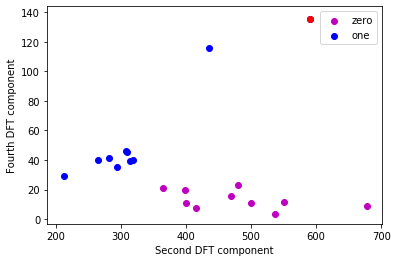

In [11]:
check_invariance_to_translation(1, 5, 2, 0)

This result confirms the theory seen in class; translation does not affect the second and fourth DFT coefficient (it only affects the first one).

We could also check invariance to scaling, but this brings difficulties when deciding on which resolution to use after scaling, so we left this open for further discussion. 

It is worth mentioning that we tried to divide every DFT coefficient by an arbitrary coefficient for every contour in order to get a ratio without the scaling-factor that could be present in the contour signal.

This lead to 'ratios invariant to scaling' of the contours signals. However, it did not improve the previous clusterings. An example can be seen below, where every contour was mutiplied by the inverse of the magnitude of the fourth coefficient.

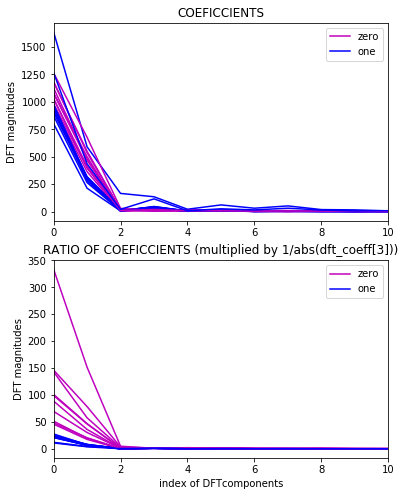

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

for i in range(nb_im):
    dft_coeff = zeros_dft_coeff[i]
    ax1.plot(np.arange(0, dft_coeff.shape[0]),np.abs(dft_coeff), color='m') # 1/dft_coef[3]
    dft_coeff = ones_dft_coeff[i]
    ax1.plot(np.arange(0, dft_coeff.shape[0]),np.abs(dft_coeff), color='b') # 1/dft_coef[3]    
for i in range(nb_im):
    dft_coeff = zeros_dft_coeff[i]
    ax2.plot(np.arange(0, dft_coeff.shape[0]), 1/np.abs(dft_coeff[3]) * np.abs(dft_coeff), color='m') # 1/abs(dft_coef[3])
    dft_coeff = ones_dft_coeff[i]
    ax2.plot(np.arange(0, dft_coeff.shape[0]), 1/np.abs(dft_coeff[3]) * np.abs(dft_coeff), color='b') # 1/abs(dft_coef[3])  

ax1.set_xlim([0, 10])
ax2.set_xlim([0, 10])
ax1.legend(('zero', 'one'))
ax2.legend(('zero', 'one'))
ax1.set_ylabel('DFT magnitudes')
ax2.set_xlabel('index of DFTcomponents')
ax2.set_ylabel('DFT magnitudes')
ax1.set_title('COEFICCIENTS')
ax2.set_title('RATIO OF COEFICCIENTS (multiplied by 1/abs(dft_coeff[3]))')

plt.show()

### 1.3 Additional method(s)

Suggestions for some additional methods are the following:
1. Comparing compacity.
2. Comparing rectangularity, which is the maximum ratio between the surface of the object and that of the circumscript rectangle, which can have any orientation. The difficulty here lies in finding the circumscript rectangle for every orientation.
3. Comparing elongation, which is the ratio between the maximum diameter of the object and its minimum diameter perpendicular to it; or also, the square root of the ratio of the eigenvalues of the matrix of inertia.
4. Comparing projections, that is, we compare the width and height of each digit.


(We could also have checked whether the digit contains a hole, which can be done by checking if the function ```skimage.measure.find_contours``` detects either one or two contours. This is equivalent to (and easier than) comparing the ratio of enclosed white pixels over all enclosed pixels of each outer boundary. (This can be done with the function ```region_growing``` from the previous lab.) (For a zero digit, this ratio should be strictly less than 1; for a one digit, the ratio should be equal to 1.))

We now check for compacity:

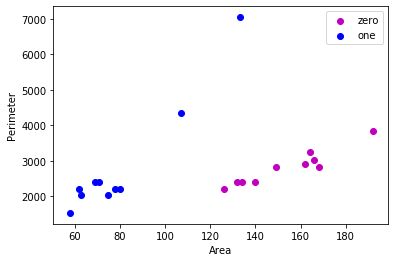

In [13]:
#1. Compacity
zeros_areas = [np.count_nonzero(image) for image in zeros_processed]
ones_areas = [np.count_nonzero(image) for image in ones_processed]

zeros_perimeters_squared = [contour.shape[0]**2 for contour in zeros_contours]
ones_perimeters_squared = [contour.shape[0]**2 for contour in ones_contours]

zero = plt.scatter(zeros_areas, zeros_perimeters_squared, color='m')
one = plt.scatter(ones_areas, ones_perimeters_squared, color='b')
plt.legend((zero, one), ('zero', 'one'))
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.show()

We now check for rectangularity:

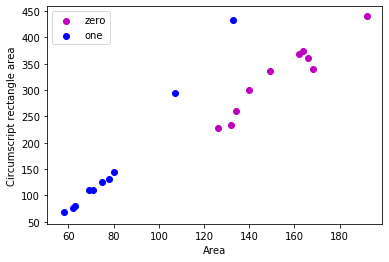

In [14]:
#2. Rectangularity
def first_nonzero(array, axis, invalid_val=-1):
    mask = array!=0
    indices = np.where(mask.any(axis=axis), mask.argmax(axis=axis), invalid_val)
    for i in range(len(indices)):
        if indices[i] == -1:
            indices[i] = 28
    return indices

def last_nonzero(array, axis, invalid_val=-1):
    mask = array!=0
    val = array.shape[axis] - np.flip(mask, axis=axis).argmax(axis=axis) - 1
    return np.where(mask.any(axis=axis), val, invalid_val)

zeros_im_straightened = [straighten(image) for image in zeros_processed]
ones_im_straightened = [straighten(image) for image in ones_processed]

zeros_rectangle_areas = [(np.max(last_nonzero(image,0))-np.min(first_nonzero(image,0)))
                          *(np.max(last_nonzero(image,1))-np.min(first_nonzero(image,1)))
                          for image in zeros_im_straightened]
ones_rectangle_areas = [(np.max(last_nonzero(image,0))-np.min(first_nonzero(image,0)))
                          *(np.max(last_nonzero(image,1))-np.min(first_nonzero(image,1)))
                          for image in ones_im_straightened]

zero = plt.scatter(zeros_areas, zeros_rectangle_areas, color='m')
one = plt.scatter(ones_areas, ones_rectangle_areas, color='b')
plt.legend((zero, one), ('zero', 'one'))
plt.xlabel('Area')
plt.ylabel('Circumscript rectangle area')
plt.show()

As can be seen from the code above, we only used our self-written function ```straighten``` to somewhat optimize the circumscript rectangle; this has a good effect on digits 1 that consist of only one line segment. However, for the digits 1 with indices 5 and 9, this straightening effect offers no advantage. We could therefore possibly iterate over the circumscript rectangles after each rotation from 0 to 360 degrees to find the optimal one (with smallest area); however, this might not only negatively affect the running time, but it will also not have any significant effect on the scatter plot since these two outliers will clearly never be close to the blue cluster. It would therefore be more beneficial to find a way to remove the redundant line segments on those two specific digits 1.

We now check for elongation:

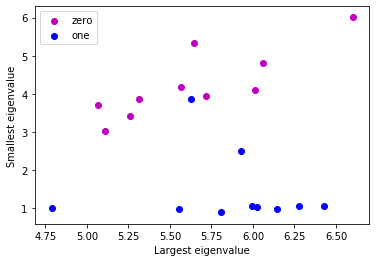

In [15]:
#3. Elongation
from skimage.measure import inertia_tensor_eigvals

zeros_eigvals = [inertia_tensor_eigvals(image) for image in zeros_processed]
ones_eigvals = [inertia_tensor_eigvals(image) for image in ones_processed]

zero = plt.scatter([np.sqrt(eigvals[0]) for eigvals in zeros_eigvals], [np.sqrt(eigvals[1]) for eigvals in zeros_eigvals], color='m')
one = plt.scatter([np.sqrt(eigvals[0]) for eigvals in ones_eigvals], [np.sqrt(eigvals[1]) for eigvals in ones_eigvals], color='b')
plt.legend((zero, one), ('zero', 'one'))
plt.xlabel('Largest eigenvalue')
plt.ylabel('Smallest eigenvalue')
plt.show()

Once more, we see that there would have been no trouble if only the digits 1 with indices 5 and 9 had had their extra line segments removed (they are now representing again two blue outliers). 

We now check for projections:

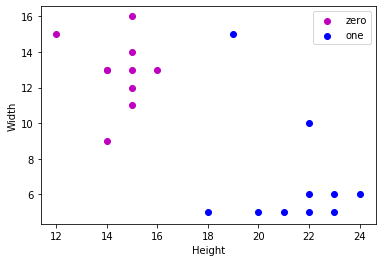

In [16]:
#4. Projections
def count_projections(image, axis):
    return np.count_nonzero(image, axis=axis)

zeros_heights = [np.max(count_projections(image, 0)) for image in zeros_processed]
ones_heights = [np.max(count_projections(straighten(image), 0)) for image in ones_processed]

zeros_widths = [np.max(count_projections(image, 1)) for image in zeros_processed]
ones_widths = [np.max(count_projections(straighten(image), 1)) for image in ones_processed]

zero = plt.scatter(zeros_heights, zeros_widths, color='m')
one = plt.scatter(ones_heights, ones_widths, color='b')
plt.legend((zero, one), ('zero', 'one'))
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()

The above representation seems the most promising until now. Note that we did straighten the digits 1 before calculating the width and height.

## Part 2
The `lab-02-data/part2` folder contains grey-scale pictures of handwritten "2" and "3".
Extract the same feature (typically 2 Fourier descriptors) as in part 1 also on these images and plot them on the same graph as the features of the "0" and "1".
Is it possible to discriminate all these 4 digits with a 2-dimensional feature vector?

### 2.1 Data visualization

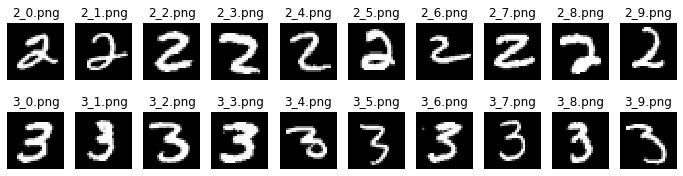

In [17]:
#  Load twos
twos_path = os.path.join(data_base_path, data_folder, 'part2', '2')
twos_names = [nm for nm in os.listdir(twos_path) if '.png' in nm]  # make sure to only load .png
twos_names.sort()  # sort file names
ic = skimage.io.imread_collection([os.path.join(twos_path, nm) for nm in twos_names])
twos_im = skimage.io.concatenate_images(ic)
#  Load threes
threes_path = os.path.join(data_base_path, data_folder, 'part2', '3')
threes_names = [nm for nm in os.listdir(threes_path) if '.png' in nm]  # make sure to only load .png
threes_names.sort()  # sort file names
ic = skimage.io.imread_collection(([os.path.join(threes_path, nm) for nm in threes_names]))
threes_im = skimage.io.concatenate_images(ic)

# Plot images
fig, axes = plt.subplots(2, len(twos_im), figsize=(12, 3))
for ax, im, nm in zip(axes[0], twos_im, twos_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)
for ax, im, nm in zip(axes[1], threes_im, threes_names):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(nm)

### 2.2 Additional method(s) and conclusion
#### 2.2.1 Pre-processing
Our pre-processing approach once again consists of binarization and applying mathematical morphology techniques.

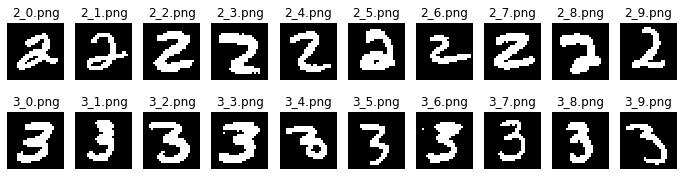

In [18]:
#1. Binarization
twos_binarized = binarize_images(twos_im, 40)
threes_binarized = binarize_images(threes_im, 40)

show_numbers(twos_binarized, twos_names, 
             threes_binarized, threes_names, contours = False)

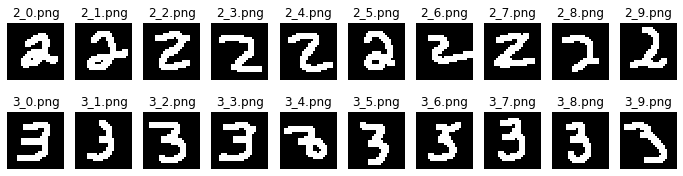

In [19]:
#2. Mathematical morphology
twos_processed = preprocess_images(twos_binarized)
threes_processed = preprocess_images(threes_binarized)

show_numbers(twos_processed, twos_names, 
             threes_processed, threes_names, contours = False)

#### 2.2.2 Fourier descriptors
We compute the DFT coefficients of the outer contours.

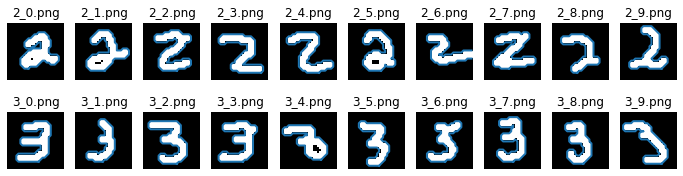

In [20]:
twos_contours = [max(measure.find_contours(image, 0), key=len) for image in twos_processed]
threes_contours = [max(measure.find_contours(image, 0), key=len) for image in threes_processed]

show_numbers(twos_processed, twos_names, twos_contours,
            threes_processed, threes_names, threes_contours)

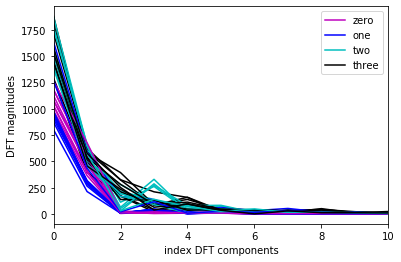

In [21]:
twos_dft_coeff = [fft(contour[:,1]+contour[:,0]*1j) for contour in twos_contours]
threes_dft_coeff = [fft(contour[:,1]+contour[:,0]*1j) for contour in threes_contours]

for i in range(nb_im):
    dft_coeff = zeros_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='m')
    dft_coeff = ones_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='b')    
    dft_coeff = twos_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='c')
    dft_coeff = threes_dft_coeff[i]
    plt.plot(np.arange(0, dft_coeff.shape[0]), np.abs(dft_coeff), color='k')
    
plt.xlim((0, 10))

plt.legend(('zero', 'one', 'two', 'three'))
plt.xlabel('index DFT components')
plt.ylabel('DFT magnitudes')
plt.show()

Magenta displays the magnitude of the DFT coefficients for the 0 digits, dark blue for the 1 digits, cyan for the 2 digits, and black for the 3 digits. The next scatter plot visualizes once again the second and fourth DFT coefficients for each digit.

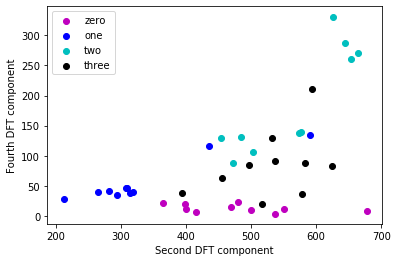

In [22]:
zero = plt.scatter(zeros_second, zeros_fourth, color='m')
one = plt.scatter(ones_second, ones_fourth, color='b')

#twos_first = [np.abs(twos_dft_coeff[i][0]) for i in range(nb_im)]
twos_second = [np.abs(twos_dft_coeff[i][1]) for i in range(nb_im)]
twos_fourth = [np.abs(twos_dft_coeff[i][3]) for i in range(nb_im)]
two = plt.scatter(twos_second, twos_fourth, color='c')

#threes_first = [np.abs(threes_dft_coeff[i][0]) for i in range(nb_im)]
threes_second = [np.abs(threes_dft_coeff[i][1]) for i in range(nb_im)]
threes_fourth = [np.abs(threes_dft_coeff[i][3]) for i in range(nb_im)]
three = plt.scatter(threes_second, threes_fourth, color='k')

plt.legend((zero, one, two, three), ('zero', 'one', 'two', 'three'))
plt.xlabel('Second DFT component')
plt.ylabel('Fourth DFT component')
plt.show()

As can be seen on the scatter plot above, there is still some distinguishability between the areas occupied by each of the four digits; however not easily separable. (The two dark blue outliers are also still very clearly present.)

We can thus try out our other features as well.

We start off by compacity:

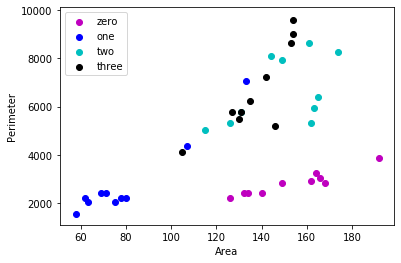

In [23]:
#1. Compacity
twos_areas = [np.count_nonzero(image) for image in twos_processed]
threes_areas = [np.count_nonzero(image) for image in threes_processed]

twos_perimeters_squared = [contour.shape[0]**2 for contour in twos_contours]
threes_perimeters_squared = [contour.shape[0]**2 for contour in threes_contours]

zero = plt.scatter(zeros_areas, zeros_perimeters_squared, color='m')
one = plt.scatter(ones_areas, ones_perimeters_squared, color='b')
two = plt.scatter(twos_areas, twos_perimeters_squared, color='c')
three = plt.scatter(threes_areas, threes_perimeters_squared, color='k')
plt.legend((zero, one, two, three), ('zero', 'one', 'two', 'three'))
plt.xlabel('Area')
plt.ylabel('Perimeter')
plt.show()

Not very impressive.

We now check for rectangularity (we don't straighten the digits 2 and 3):

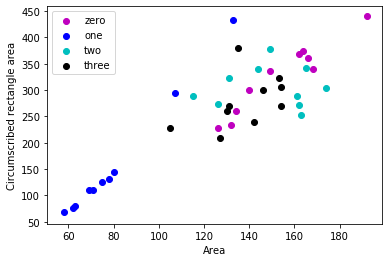

In [24]:
#2. Rectangularity
twos_rectangle_areas = [(np.max(last_nonzero(image,0))-np.min(first_nonzero(image,0)))
                          *(np.max(last_nonzero(image,1))-np.min(first_nonzero(image,1)))
                          for image in twos_processed]
threes_rectangle_areas = [(np.max(last_nonzero(image,0))-np.min(first_nonzero(image,0)))
                          *(np.max(last_nonzero(image,1))-np.min(first_nonzero(image,1)))
                          for image in threes_processed]

zero = plt.scatter(zeros_areas, zeros_rectangle_areas, color='m')
one = plt.scatter(ones_areas, ones_rectangle_areas, color='b')
two = plt.scatter(twos_areas, twos_rectangle_areas, color='c')
three = plt.scatter(threes_areas, threes_rectangle_areas, color='k')
plt.legend((zero, one, two, three), ('zero', 'one', 'two', 'three'))
plt.xlabel('Area')
plt.ylabel('Circumscribed rectangle area')
plt.show()

Not very satisfying either.

We now check for elongation:

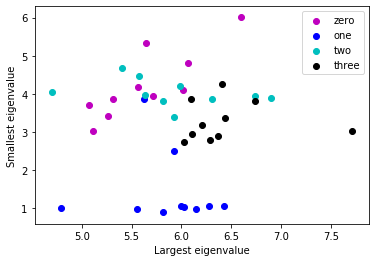

In [25]:
#3. Elongation
twos_eigvals = [inertia_tensor_eigvals(image) for image in twos_processed]
threes_eigvals = [inertia_tensor_eigvals(image) for image in threes_processed]

zero = plt.scatter([np.sqrt(eigvals[0]) for eigvals in zeros_eigvals], [np.sqrt(eigvals[1]) for eigvals in zeros_eigvals], color='m')
one = plt.scatter([np.sqrt(eigvals[0]) for eigvals in ones_eigvals], [np.sqrt(eigvals[1]) for eigvals in ones_eigvals], color='b')
two = plt.scatter([np.sqrt(eigvals[0]) for eigvals in twos_eigvals], [np.sqrt(eigvals[1]) for eigvals in twos_eigvals], color='c')
three = plt.scatter([np.sqrt(eigvals[0]) for eigvals in threes_eigvals], [np.sqrt(eigvals[1]) for eigvals in threes_eigvals], color='k')
plt.legend((zero, one, two, three), ('zero', 'one', 'two', 'three'))
plt.xlabel('Largest eigenvalue')
plt.ylabel('Smallest eigenvalue')
plt.show()

Not very impressive either.

At last, we check for projections:

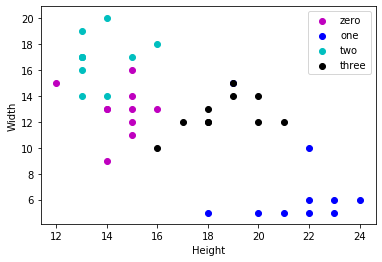

In [26]:
#4. Projections
twos_heights = [np.max(count_projections(image, 0)) for image in twos_processed]
threes_heights = [np.max(count_projections(straighten(image), 0)) for image in threes_processed]

twos_widths = [np.max(count_projections(image, 1)) for image in twos_processed]
threes_widths = [np.max(count_projections(straighten(image), 1)) for image in threes_processed]

zero = plt.scatter(zeros_heights, zeros_widths, color='m')
one = plt.scatter(ones_heights, ones_widths, color='b')
two = plt.scatter(twos_heights, twos_widths, color='c')
three = plt.scatter(threes_heights, threes_widths, color='k')
plt.legend((zero, one, two, three), ('zero', 'one', 'two', 'three'))
plt.xlabel('Height')
plt.ylabel('Width')
plt.show()

We can thus conclude that the projection features of the digits are the most promising when it comes to clustering. (Notice that we straightened the digits 1 and 3 this time.)

We can thus conclude that, yes, it is possible to discriminate all these 4 digits with a 2-dimensional feature vector. We succeeded at doing this with the features of projection (see last plot above) (after implicitly straightening the digits 1 and 3).